In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten, Input

In [3]:
# Load dataset
df = pd.read_csv("AAPL.csv")

In [5]:
# Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Close']].values  # Extract Close Price

In [7]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [9]:
# Create Sequences (60 days as input, next day as output)
SEQ_LENGTH = 60

In [11]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, SEQ_LENGTH)

In [13]:
# Split Data (80% Train, 20% Test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [15]:
# Define Model Architectures
def build_model(model_type):
    model = Sequential()
    model.add(Input(shape=(SEQ_LENGTH, 1)))
    
    if model_type == "MLP":
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
    
    elif model_type == "LSTM":
        model.add(LSTM(50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(25))
    
    elif model_type == "GRU":
        model.add(GRU(50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(25))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [17]:
# Train and Evaluate Models
models = {"MLP": build_model("MLP"), "LSTM": build_model("LSTM"), "GRU": build_model("GRU")}
model_results = {}

Training MLP model...
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


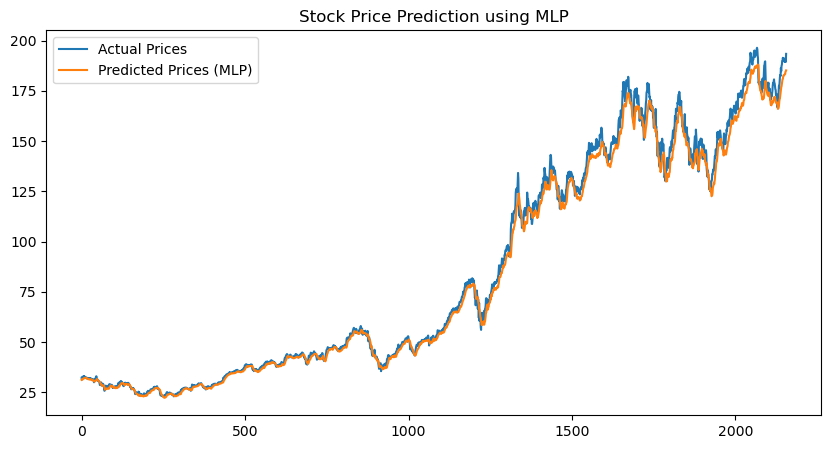

Training LSTM model...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step


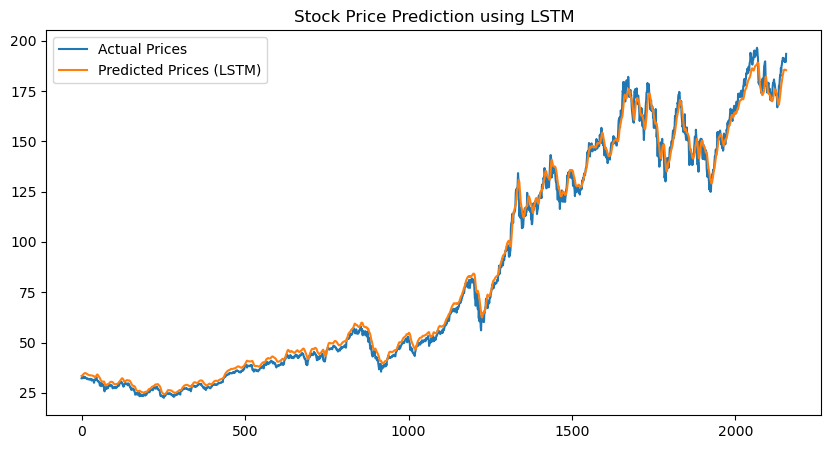

Training GRU model...
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


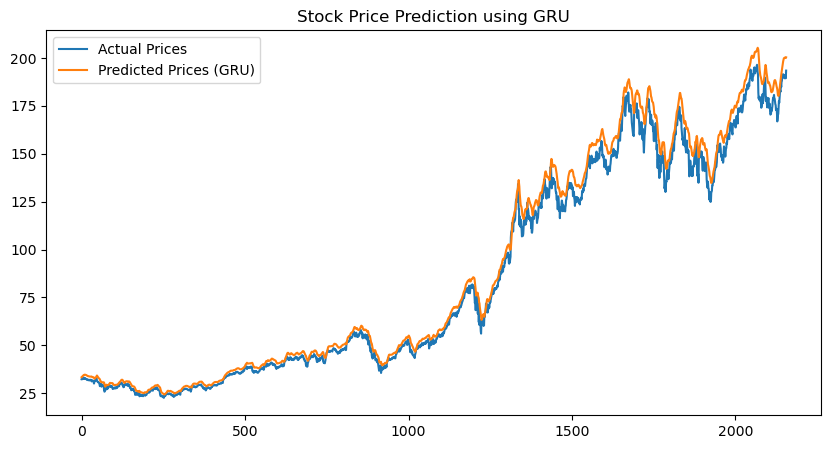

In [19]:
for model_name, model in models.items():
    print(f"Training {model_name} model...")
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Compute Metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    mae = mean_absolute_error(y_test_actual, predictions)
    
    model_results[model_name] = {"RMSE": rmse, "MAE": mae}
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label="Actual Prices")
    plt.plot(predictions, label=f"Predicted Prices ({model_name})")
    plt.legend()
    plt.title(f"Stock Price Prediction using {model_name}")
    plt.show()

In [21]:
# Print Comparison Table
print("\nModel Comparison:")
print(pd.DataFrame(model_results).T)


Model Comparison:
          RMSE       MAE
MLP   4.144015  2.820884
LSTM  3.563010  2.822007
GRU   6.086520  4.611071
